# Introduction

The Full-Width Half Maximum (FWHM) of a diffraction peak varies with the level of ordering within a crystal. This allows the FWHM to be used as a metric to distinguish amorphous alloys from crystalline alloys.

Metallic glasses are amorphous and thus, FWHM measurement can be used to predict the glass-forming ability of alloys. 

This report uses data on the glass-forming ability of three ternary subsystems (CrTiZr, CrCoZr, CoTiZr), in order to predict the glass forming ability of the quaternery Co-Zr-Cr-Ti system. To do this, a data set of 100+ features will be used and various regularization techniques will be applied to produce physically-interpretable models of the glass forming ability for the Co-Zr-Cr-Ti quaternary system.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score

from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import Miedema, YangSolidSolution, Meredig, AtomicPackingEfficiency, BandCenter, WenAlloys

In [2]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')

In [3]:
# Loading each ternery system as a separate dataframe, assigning a "Group" label to each alloy
# https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html
CrTiZr_data = pd.read_excel('Metallic Glass Data.xlsx', sheet_name = 0)
CrTiZr_data = CrTiZr_data.dropna(axis=1)
CrTiZr_data['Group'] = 1
CrCoZr_data = pd.read_excel('Metallic Glass Data.xlsx', sheet_name = 1)
CrCoZr_data = CrCoZr_data.dropna(axis=1)
CrCoZr_data['Group'] = 2
CoTiZr_data = pd.read_excel('Metallic Glass Data.xlsx', sheet_name = 2)
CoTiZr_data = CoTiZr_data.dropna(axis=1)
CoTiZr_data['Group'] = 3

## 0.0 Helper Functions

In [4]:
# Function that drops columns that have repeated values
def drop_constant_columns(df):
    columns = df.columns
    drop_cols = []
    
    # Iterate over the columns and check if they have constant values
    for col in columns:
        if df[col].nunique() == 1:
            drop_cols.append(col)
    
    #Drop the constant columns
    result_df = df.drop(drop_cols, axis=1)
    
    return result_df

In [5]:
# From Assignment 5
def parity_plot(y_true, y_pred, title=None):
    """
    Create a parity plot of data predicted by a linear regression model.
    """
    fig, ax = plt.subplots()
    figure(figsize=(4,2), dpi=80)

    ax.scatter(y_true, y_pred, alpha=0.5)
    max_val = max(np.max(y_true), np.max(y_pred))
    ax.plot([0, max_val], [0, max_val], color='red', linestyle='--')
    ax.set_xlabel('True FWHM Values')
    ax.set_ylabel('Predicted FWHM Values')
    r2 = r2_score(y_true, y_pred)
    if title is not None:
        ax.set_title(title + ' (R$^2$={:.3f})'.format(r2))
    else:
        ax.set_title('Parity Plot (R$^2$={:.3f})'.format(r2))
    plt.show()

In [6]:
# Drop columns that are not numeric
def drop_nonnumeric_columns(df, exclude_cols=None):
    # get the column names
    columns = df.columns
    
    # create a list to store the non-numeric columns to drop
    drop_cols = []
    
    # iterate over the columns and check if they are non-numeric
    for col in columns:
        if not np.issubdtype(df[col].dtype, np.number):
            # check if the column is in the exclude list
            if exclude_cols is None or col not in exclude_cols:
                drop_cols.append(col)
    
    # drop the non-numeric columns
    result_df = df.drop(drop_cols, axis=1)
    
    return result_df

In [7]:
# Calculation polynomial combinations of features
# From ChatGPT
def create_product_columns(df):
    # get the column names
    columns = df.columns
    
    # create a new dataframe to store the product columns
    product_df = pd.DataFrame()
    
    # iterate over the columns and create new product columns
    for i in range(len(columns)-1):
        col1 = columns[i]
        col2 = columns[i+1]
        # check if the columns are numeric
        if np.issubdtype(df[col1].dtype, np.number) and np.issubdtype(df[col2].dtype, np.number):
            product_col = col1 + '_' + col2 + '_product'
            product_df[product_col] = df[col1] * df[col2]
    
    # concatenate the original dataframe and the product dataframe
    result_df = pd.concat([df, product_df], axis=1)
    
    return result_df

In [8]:
# Create custom column product combinations
def custom_column_product(df, columns, new_column_name):
    result_df = df.copy()
    
    # create the new column as the product of the specified columns
    result_df[new_column_name] = result_df[columns].prod(axis=1)
    
    return result_df


In [9]:
def combine_dataframes(df1, df2):
    common_columns = list(set(df1.columns) & set(df2.columns))
    # Merge dataframes on the common columns
    # https://sparkbyexamples.com/pandas/pandas-outer-join-explained-by-examples/#:~:text=Outer%20join%20is%20also%20called,returns%20null%20on%20respective%20cells.
    df_merged = pd.merge(df1, df2, on=common_columns, how='outer')
    # Put zeros for missing values
    df_merged.fillna(0, inplace=True)
    return df_merged

In [10]:
# Modified parity_plot function myself
# Plots parity plot of standard vs regularized model predictions
def parity_plot_custom(y_true, y_pred, title=None):
    fig, ax = plt.subplots()
    figure(figsize=(4,2), dpi=80)

    ax.scatter(y_true, y_pred, alpha=0.5)
    max_val = max(y_true.max()[0], y_pred.max())
    ax.plot([0, max_val], [0, max_val], color='red', linestyle='--')
    ax.set_xlabel('Standard Model FWHM Values')
    ax.set_ylabel('Regularized Model FWHM Values')
    r2 = r2_score(y_true, y_pred)
    if title is not None:
        ax.set_title(title + ' (R$^2$={:.3f})'.format(r2))
    else:
        ax.set_title('Parity Plot (R$^2$={:.3f})'.format(r2))
    plt.show()

In [11]:
# Used ChatGPT and modified myself for random cv, plotting r2, and standardization
def lasso_feature_selection(X, y, n_splits):
    
    # Do 80/20 train-test split per forld
    cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    
    # Try alpha values between 10^-10 and 1
    alphas = np.logspace(-5.5, 1, 200)
    

    # Initialize arrays to store training and validation errors and coefficient values for each alpha
    train_errors = np.zeros_like(alphas)
    val_errors = np.zeros_like(alphas)
    coef_values = np.zeros((len(alphas), X.shape[1]))
    r2_scores = np.zeros_like(alphas)
    
    # Iterate over alphas
    for i, alpha in enumerate(alphas):
        
        # Initialize LASSO model with current alpha value
        # Tolerance and maximum iterations is increased to allow for convergence
        lasso = Lasso(alpha=alpha, max_iter=2000, tol=0.07, fit_intercept=True)

        # Initialize arrays to store training and validation errors and coefficient values for current alpha
        alpha_train_errors = np.zeros(n_splits)
        alpha_val_errors = np.zeros(n_splits)
        alpha_coef_values = np.zeros((n_splits, X.shape[1]))
        alpha_r2_scores = np.zeros(n_splits)

        # Perform cross validation
        for j, (train_index, val_index) in enumerate(cv.split(X)):
            # Get training and validation data for current split
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_val, y_val = X.iloc[val_index], y.iloc[val_index]

            # Standarize current fold training data
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            
            # Transform validation data x-values
            X_val = scaler.transform(X_val)
            
            # Fit model
            lasso.fit(X_train, y_train)

            # Calculate training and validation errors and coefficient values for current split
            y_pred_train = lasso.predict(X_train)
            y_pred_test = lasso.predict(X_val)

            alpha_train_errors[j] = np.mean((y_train - y_pred_train)**2)
            alpha_val_errors[j] = np.mean((y_val - y_pred_test)**2)
            alpha_coef_values[j, :] = lasso.coef_
            alpha_r2_scores[j] = r2_score(y_val, y_pred_test)
        
        # Calculate mean training and validation errors and coefficient values for current alpha
        train_errors[i] = np.mean(alpha_train_errors)
        val_errors[i] = np.mean(alpha_val_errors)
        coef_values[i, :] = np.mean(alpha_coef_values, axis=0) # get average feature coefficients 
        r2_scores[i] = np.mean(alpha_r2_scores)
        
    # Determine optimal alpha value, i.e. the one that minimizes the validation set error
    opt_alpha = alphas[np.argmin(val_errors)]
    min_validation_error = np.argmin(val_errors)

    # Plot training and validation errors as a function of alpha
    fig, ax = plt.subplots()
    ax.semilogx(alphas, train_errors, label='Training error')
    ax.semilogx(alphas, val_errors, label='Validation error')
    plt.xlabel('Alpha')
    plt.ylabel('Mean squared error')
#     plt.axvline(x=opt_alpha, color='red', linestyle='dashdot') # vertical dashed line for optimal alpha value
    plt.title('LASSO feature selection')
    plt.legend()
    
    # Plot R2 score as a function of alpha
    fig, ax = plt.subplots()
    ax.semilogx(alphas, r2_scores)
    plt.xlabel('Alpha')
    plt.ylabel('R squared value')
    plt.title('R2 Score vs alpha')
    plt.show()

    # Plot coefficient values as a function of alpha
    fig, ax = plt.subplots()
    ax.semilogx(alphas, coef_values)
    plt.xlabel('Alpha')
    plt.ylabel('Coefficient values')
    plt.title('LASSO coefficients')
    plt.tight_layout()
    plt.show()
    
#     # Get which features have coefficients close to 0
#     zero_coefs = X.columns[abs(coef_values) < 0.001]
#     print(f"Features with coefficients close to 0: {zero_coefs}")

    return opt_alpha, min_validation_error, coef_values

In [12]:
def reduce_dataset(full_x, desired_alpha):
    # Standardize features
    X_train_optimal_alpha = full_x
    lasso_optimal_alpha_scaler = StandardScaler()
    lasso_optimal_alpha_scaler.fit(X_train_optimal_alpha)
    X_train_optimal_alpha = lasso_optimal_alpha_scaler.transform(X_train_optimal_alpha)

    # Fit Lasso model with optimal alpha value as determined from Section 2.1-2.2
    lasso_optimal_alpha = Lasso(alpha=desired_alpha, max_iter=2000, tol=0.07, fit_intercept=True)
    lasso_optimal_alpha.fit(X_train_optimal_alpha, full_y)
    print(f"The original dataset had {full_x.shape[1]} features")
    print(f"After performing LASSO, with the optimal alpha, the reduced feature set has {len(lasso_optimal_alpha.coef_[abs(lasso_optimal_alpha.coef_) > 0])} features")

    # Choosing only features with coefficients greater than abs(0.001)
    optimal_alpha_coefs = lasso_optimal_alpha.coef_
    important_coefs = abs(optimal_alpha_coefs) > 0
    
    # return NON-STANDARDIZED slice of original full feature set
    filtered_full_x_optimal_alpha = full_x.loc[:, important_coefs] # Reduced feature set using
    
    return filtered_full_x_optimal_alpha

In [13]:
# Plot parity plots of the test sets of each fold in 5-fold cross validation for alpha = 0.001 
def cv_parity_plot(X, y, n_splits):
    
    # Do 80/20 train-test split per forld
    cv = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    
    # Try alpha values between 10^-10 and 1
    alphas = np.array([0.001])
    
    # Initialize arrays to store training and validation errors and coefficient values for each alpha
    train_errors = np.zeros_like(alphas)
    val_errors = np.zeros_like(alphas)
    coef_values = np.zeros((len(alphas), X.shape[1]))
    r2_scores = np.zeros_like(alphas)
    
    # Iterate over alphas
    for i, alpha in enumerate(alphas):
        
        # Initialize LASSO model with current alpha value
        # Tolerance and maximum iterations is increased to allow for convergence
        lasso = Lasso(alpha=0.001, max_iter=2000, tol=0.07, fit_intercept=True)

        # Initialize arrays to store training and validation errors and coefficient values for current alpha
        alpha_train_errors = np.zeros(n_splits)
        alpha_val_errors = np.zeros(n_splits)
        alpha_coef_values = np.zeros((n_splits, X.shape[1]))
        alpha_r2_scores = np.zeros(n_splits)

        # Perform cross validation
        for j, (train_index, val_index) in enumerate(cv.split(X)):
            # Get training and validation data for current split
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_val, y_val = X.iloc[val_index], y.iloc[val_index]

            # Standarize current fold training data
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            
            # Transform validation data x-values
            X_val = scaler.transform(X_val)
            
            # Fit model
            lasso.fit(X_train, y_train)

            # Calculate training and validation errors and coefficient values for current split
            y_pred_train = lasso.predict(X_train)
            y_pred_test = lasso.predict(X_val)
            
            
            parity_plot(y_val, y_pred_test, title=f"Parity Plot on Test Set of Fold {j + 1}")
            
            alpha_train_errors[j] = np.mean((y_train - y_pred_train)**2)
            alpha_val_errors[j] = np.mean((y_val - y_pred_test)**2)
            alpha_coef_values[j, :] = lasso.coef_
            alpha_r2_scores[j] = r2_score(y_val, y_pred_test)
            print(f"The training error on this fold is {round(alpha_train_errors[j], 4)}")
            print(f"The validation error on this fold is {round(alpha_val_errors[j], 4)}")
    
    return None

In [14]:
# Determine which features has the highest coefficienct
def get_names_important_features(model, num_important_features, feature_names_list):
    """
    Return the most useful features (highest magnitude coefficients) of a regularized model 
    """
    # Get array of magnitudes of each feature
    coefs = abs(model.coef_)
    
    # Get indices of highest 
    highest_indices = coefs.argsort()[-num_important_features:]
    
    selected_values = feature_names_list[highest_indices]
    
    return selected_values

# 1.0 Data pre-processing

In [15]:
combined_data = combine_dataframes(CrTiZr_data, CrCoZr_data)
combined_data = combine_dataframes(CoTiZr_data, combined_data)
combined_data = combined_data[['Co', 'Ti', 'Zr','Cr','MaxFWHM', 'Group']]

In [16]:
# Drop missing values, duplicates
combined_data = combined_data.dropna()
combined_data = combined_data.drop_duplicates()
combined_data.corr().iloc[:4,:4] > abs(0.8)

,Co,Ti,Zr,Cr
Co,True,False,False,False
Ti,False,True,False,False
Zr,False,False,True,False
Cr,False,False,False,True


No features are highly correlated and thus, none are dropped



## 1.1 Generating an informative feature set of at least 100 entries

Please uncomment the cells specified below if you would like to featurize the dataset from matminer manually. Since this takes ~15 minutes to perform, **the featurized data is loaded from a saved .csv file called "final_featurized.csv" which is available on GitHub and must be in the same direction as this .ipynb file during runtime**

Features were selected based on a few informed decisions. For example, Miedema parameters directly calculated glass-forming ability, which affects FWHM values, and WenAlloys includes Yang's parameters. WenAlloys and Meredig also includes mean electronegativity- and atomic radii-related features, both of which inform solid-solution forming abilities (Hume-Rothery Rules). Since electrons inform most bonding properties, BandCenter and AtomicOrbital featurizers were used as well.

-----Uncomment cells below this line to redo matminer featurization-----

In [17]:
# # Add chemical formula column to facilitate featurization with matminer
# featurized_data = combined_data
# formula = 'Co'+combined_data['Co'].astype(str)+'Ti'+combined_data['Ti'].astype(str)+'Zr'+combined_data['Zr'].astype(str)+'Cr'+combined_data['Cr'].astype(str)
# featurized_data['Formula'] = pd.DataFrame(formula)
# featurized_data = featurized_data[['Formula', 'Co', 'Ti', 'Zr','Cr','MaxFWHM', 'Group']]

# # #convert the formula from a string into chemical composition
# featurized_data = StrToComposition().featurize_dataframe(featurized_data, "Formula")
# featurized_data = Miedema().featurize_dataframe(featurized_data, col_id="composition")
# featurized_data = WenAlloys().featurize_dataframe(featurized_data, col_id="composition")

In [18]:
# # Get mean and range of  atomic radius, electronegatvitiy and valence electron orbitals
# featurized_data = Meredig().featurize_dataframe(featurized_data, col_id="composition")

In [19]:
# featurized_data = AtomicPackingEfficiency().featurize_dataframe(featurized_data, col_id="composition")

In [20]:
# from matminer.featurizers.composition import BandCenter
# featurized_data = BandCenter().featurize_dataframe(featurized_data, col_id="composition")

In [21]:
# from matminer.featurizers.composition import AtomicOrbitals
# featurized_data = AtomicOrbitals().featurize_dataframe(featurized_data, col_id="composition")

In [22]:
# featurized_data = drop_constant_columns(featurized_data)

-----Uncomment cells above this line-----

In [23]:
"""
Save final features from matminer
"""
# featurized_data.to_csv("final_featurized.csv")
featurized_data = pd.read_csv("final_featurized.csv")

In [24]:
featurized_data = drop_constant_columns(featurized_data)
featurized_data = drop_nonnumeric_columns(featurized_data, exclude_cols=["Formula"])

In [25]:
features_to_drop = ['Ti fraction','Cr fraction','Co fraction','Zr fraction']
featurized_data = featurized_data.drop(features_to_drop, axis=1)

In [26]:
expanded_featurized_data = create_product_columns(featurized_data)
expanded_featurized_data = drop_constant_columns(expanded_featurized_data)

In [27]:
# drop columns with products of MaxFWHM column to prevent information leakage
features_to_drop = ['Cr_MaxFWHM_product', 'MaxFWHM_Group_product']
expanded_featurized_data = expanded_featurized_data.drop(features_to_drop, axis=1)

In [28]:
# Add three more products of custom feature combinations to achieve 100 features
expanded_featurized_data = custom_column_product(expanded_featurized_data, ["Co", "Ti", "Zr"], "Co_Ti_Zr_product")
expanded_featurized_data = custom_column_product(expanded_featurized_data, 
                                                 ['Miedema_deltaH_inter','Miedema_deltaH_amor','Miedema_deltaH_ss_min'], 
                                                 "All_Miedema_product")
expanded_featurized_data = custom_column_product(expanded_featurized_data, 
                                                 ["Co", "Ti", "Zr", "Cr"], "Co_Ti_Zr_Cr_product")
expanded_featurized_data = custom_column_product(expanded_featurized_data, 
                                                 ['Yang delta','Yang omega','APE mean'], 
                                                 "Yang delta_Yang omega_APE mean_product")

**A file called 'expanded_featurized_data.csv' must also be in the same directory as this .ipynb file**

In [29]:
# expanded_featurized_data.to_csv('expanded_featurized_data.csv')
expanded_featurized_data = pd.read_csv('expanded_featurized_data.csv')

In [30]:
# Move FWHM values to be the last column in dataframe
cols = list(expanded_featurized_data.columns)
cols.insert(1, cols.pop(cols.index('MaxFWHM')))
expanded_featurized_data = expanded_featurized_data.loc[:, cols]

In [31]:
features_to_drop = ['Group']
expanded_featurized_data = expanded_featurized_data.drop(features_to_drop, axis=1)
print(expanded_featurized_data.shape)

(1323, 103)


A feature set of 103 features was generated (combination of features and products of various columns)

# 2.0 Use LASSO to perform feature selection

## 2.1 Tune regularization coefficient using random cross-validation

The function lasso_feature_selection is used to determine the optimal alpha that minimizes the validation error. Please note that the maximum number of iterations and tolerance for convergence were increased when initializing a Lasso() estimator since convergence did not occur at the default (lower) values. Furthermore, the range of alpha values tested had a lower bound of 10<sup>-5</sup>, as at smaller values, convergence did not occur.

An example of the parameter weights vs alpha graph that is produced when the range of alphas was set to be between 10<sup>-7</sup> to 2 is shown below. It is evident that testing for alpha values below 10<sup>-5</sup> results in no change between in parameter weights and therefore do not need to be tested.

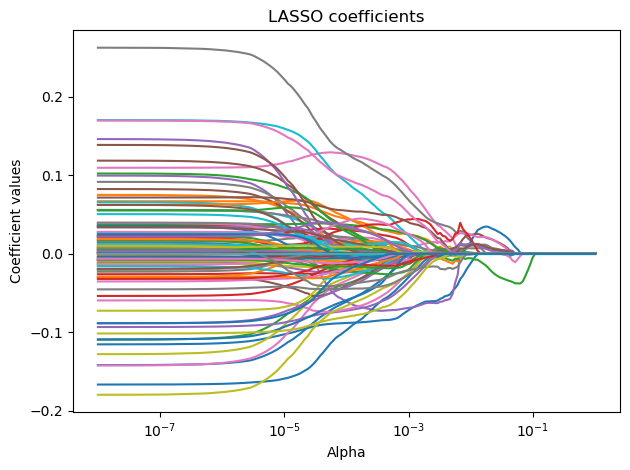

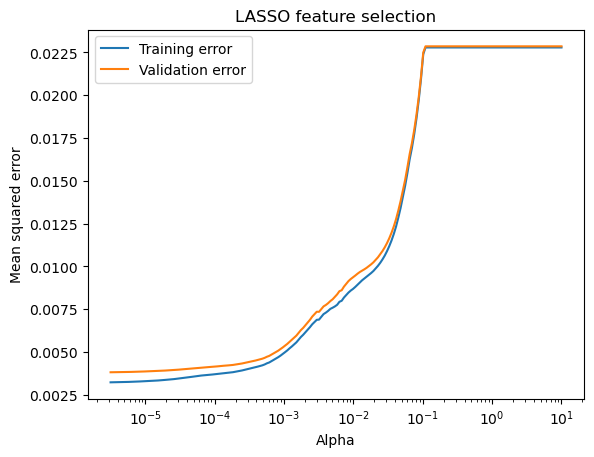

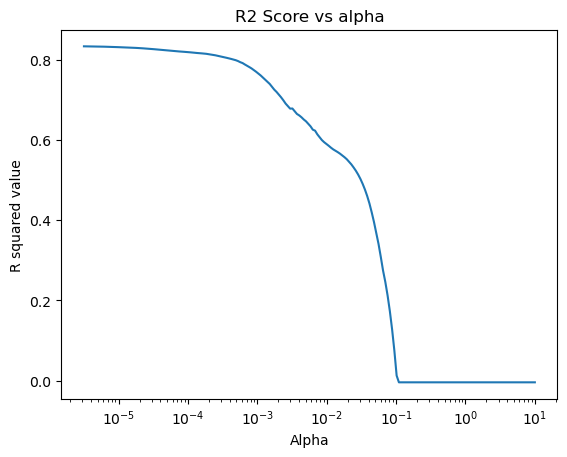

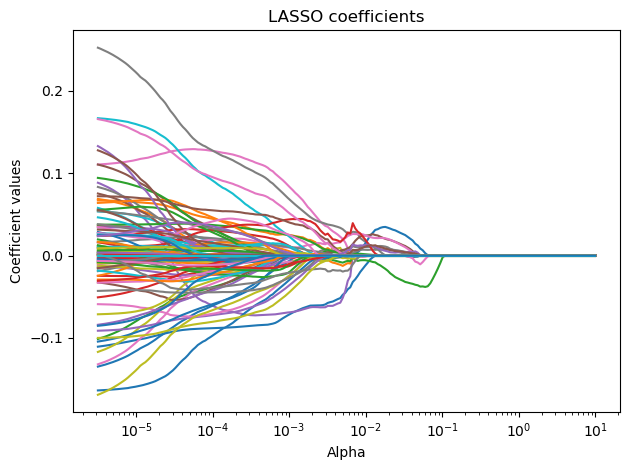

In [32]:
full_x = expanded_featurized_data.iloc[:,2:]
full_y = expanded_featurized_data.iloc[:,1]
cv_optimal_alpha, cv_validation_error, cv_coefficients = lasso_feature_selection(full_x, full_y, n_splits=5)

## 2.2 Reporting optimal α and validation error

From these graphs shown above (Section 2.1), the optimal alpha value is α = 10<sup>-4</sup>, which has a validation mean squared error of about 0.004. This is the optimal value because both the validation mean squared error and R<sup>2</sup> plateau. 

## 2.3 Dropping unimportant features

In [33]:
filtered_full_x_optimal_alpha = reduce_dataset(full_x, 0.0001)

The original dataset had 101 features
After performing LASSO, with the optimal alpha, the reduced feature set has 87 features


# 3.0 Fit another regularized model to the reduced feature set

## 3.1 Test your model’s generalizability by performing Cross Validation studies


Cross validation of a LASSO model using the reduced feature set (i.e. the one with only 87/101 features from the original matminer dataset) is conducted below. The training set and validation set mean-squared errors, as well as R-squared values, for varying regularization coefficients is also shown below:

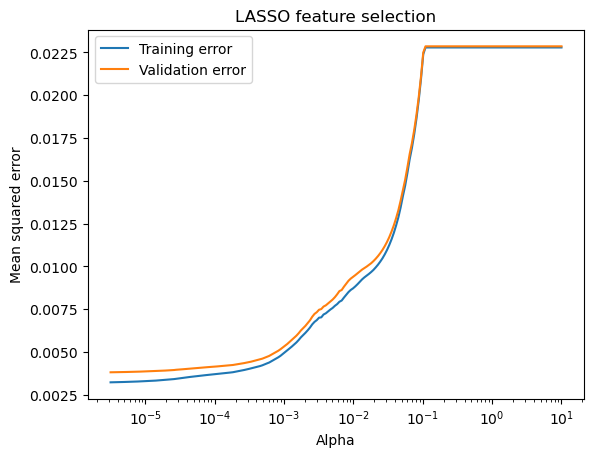

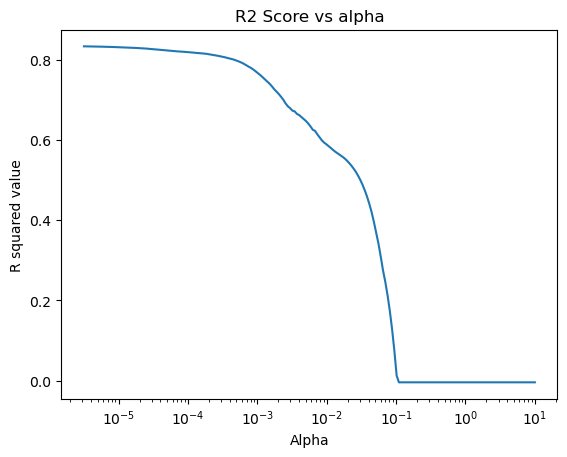

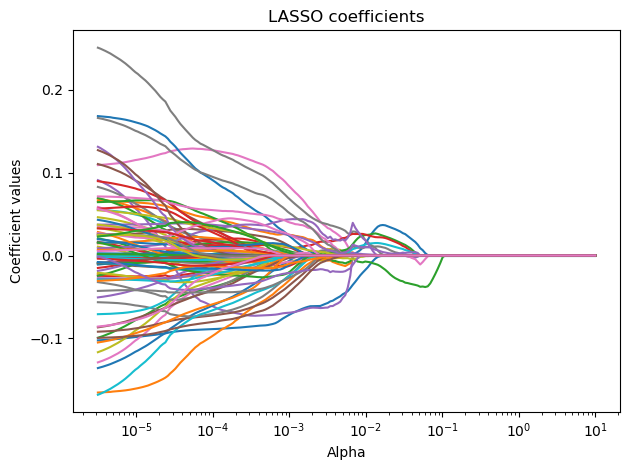

In [34]:
# Performing 80/20 train-test, 5-fold random cross validation
optimal_alpha_reduced , _, reduced_lasso_coefficients = lasso_feature_selection(filtered_full_x_optimal_alpha, full_y, 5)

From these graphs shown above, the optimal alpha value appears to be α = 10<sup>-3</sup>, which has a validation mean squared error of about 0.005 on the reduced feature set. This is the optimal value because both the validation mean squared error and R<sup>2</sup> plateau at this value.

### 3.1.1 Parity plot

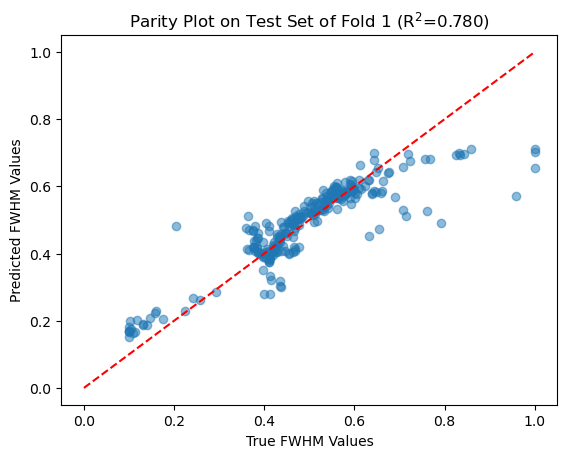

<Figure size 320x160 with 0 Axes>

The training error on this fold is 0.005
The validation error on this fold is 0.0053


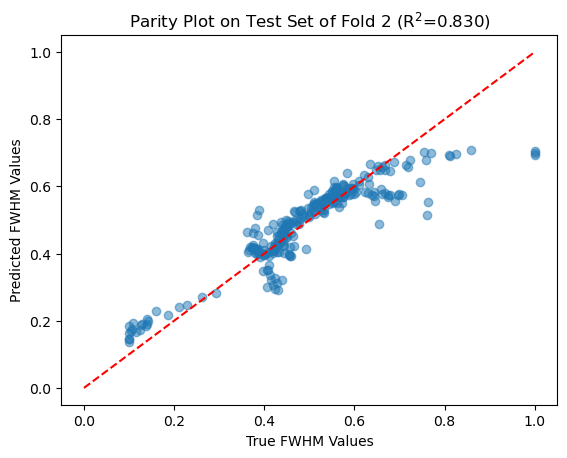

<Figure size 320x160 with 0 Axes>

The training error on this fold is 0.0053
The validation error on this fold is 0.0041


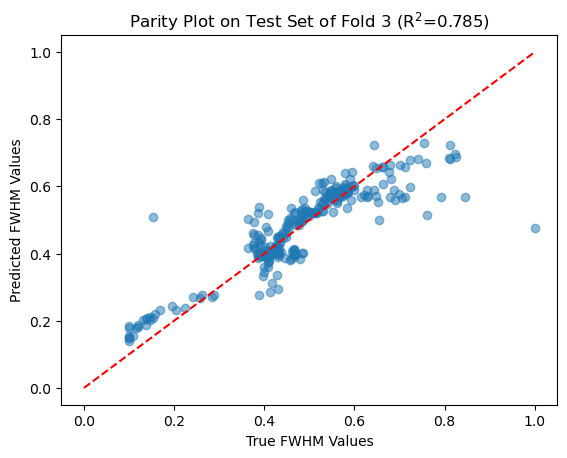

<Figure size 320x160 with 0 Axes>

The training error on this fold is 0.005
The validation error on this fold is 0.0051


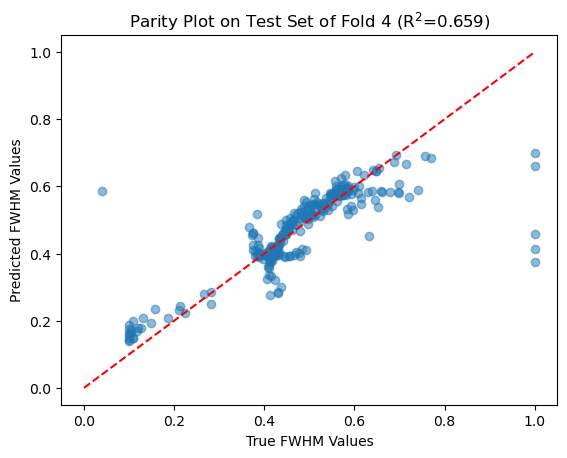

<Figure size 320x160 with 0 Axes>

The training error on this fold is 0.0043
The validation error on this fold is 0.0081


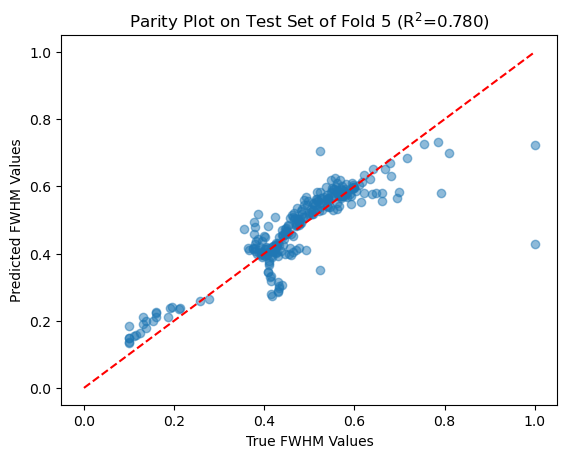

<Figure size 320x160 with 0 Axes>

The training error on this fold is 0.0051
The validation error on this fold is 0.0041


In [35]:
cv_parity_plot(filtered_full_x_optimal_alpha, full_y, 5)

### 3.1.2 Training a full matminer data model (on reduced feature set) using optimal alpha (0.001)

In [36]:
full_matminer_model_x = filtered_full_x_optimal_alpha

full_matminer_model_scaler = StandardScaler()
full_matminer_model_scaler.fit(full_matminer_model_x)
full_matminer_model_x = full_matminer_model_scaler.transform(full_matminer_model_x)

# Fit Lasso model with optimal alpha value as determined section 3.1.1
full_matminer_model = Lasso(alpha=0.001, max_iter=2000, tol=0.07, fit_intercept=True)
full_matminer_model.fit(full_matminer_model_x, full_y)

Lasso(alpha=0.001, max_iter=2000, tol=0.07)

### 3.1.3 Training a full data composition model using optimal alpha (0.001)

In [37]:
full_composition_model_x = full_x.iloc[:,:4]

full_composition_model_scaler = StandardScaler()
full_composition_model_scaler.fit(full_composition_model_x)
full_composition_model_x = full_composition_model_scaler.transform(full_composition_model_x)

# Fit Lasso model with optimal alpha value as determined section 3.1.1
full_composition_model = Lasso(alpha=0.001, max_iter=2000, tol=0.07, fit_intercept=True)
full_composition_model.fit(full_composition_model_x, full_y)

Lasso(alpha=0.001, max_iter=2000, tol=0.07)

# 4.0 Predicting the FWHM for the entire Co-Zr-Cr-Ti quaternary phase diagram (use 5 at.% increments) using both regularized composition and matminer full data models

In [38]:
# From Lab 5
# Create table of compositions for quaternary system
elements = ['Co', 'Ti', 'Zr', 'Cr']

# Define the increment for atomic fractions
increment = 0.05

# Create an empty list to store the rows of the DataFrame
rows = []

# Generate all possible combinations of atomic fractions
for i in range(0, 21):
    for j in range(0, 21):
        for k in range(0, 21):
            # Compute the atomic fraction for the last element
            l = 20 - i - j - k
            if l < 0:
                continue
            # Compute the atomic fractions for each element
            atomic_fractions = [i*increment, j*increment, k*increment, l*increment]
            # Check if the total atomic fraction is equal to 1
            total_atomic_fraction = sum(atomic_fractions)
            if total_atomic_fraction == 1:
                rows.append(atomic_fractions)

# Create a DataFrame from the list of rows
quaternary_data = pd.DataFrame(rows, columns=elements)

In [39]:
#add dummy group name column as this is dropped later
quaternary_data["MaxFWHM"] = np.random.randint(low=1, high=4, size=len(quaternary_data)) 
quaternary_data["Group"] = np.random.randint(low=1, high=4, size=len(quaternary_data)) 

---Uncomment below for manual featurization of quaternary composition data ---

In [40]:
# # Featurize quaternary composition data
# featurized_data = quaternary_data
# formula = 'Co'+featurized_data['Co'].astype(str)+'Ti'+featurized_data['Ti'].astype(str)+'Zr'+featurized_data['Zr'].astype(str)+'Cr'+featurized_data['Cr'].astype(str)
# featurized_data['Formula'] = pd.DataFrame(formula)
# featurized_data = featurized_data[['Formula', 'Co', 'Ti', 'Zr','Cr','MaxFWHM','Group']]

# # #convert the formula from a string into chemical composition
# featurized_data = StrToComposition().featurize_dataframe(featurized_data, "Formula")
# featurized_data = Miedema().featurize_dataframe(featurized_data, col_id="composition")
# featurized_data = WenAlloys().featurize_dataframe(featurized_data, col_id="composition")

In [41]:
# # Get mean and range of  atomic radius, electronegatvitiy and valence electron orbitals
# featurized_data = Meredig().featurize_dataframe(featurized_data, col_id="composition")
# featurized_data = AtomicPackingEfficiency().featurize_dataframe(featurized_data, col_id="composition")

In [42]:
# from matminer.featurizers.composition import BandCenter
# featurized_data = BandCenter().featurize_dataframe(featurized_data, col_id="composition")

In [43]:
# from matminer.featurizers.composition import AtomicOrbitals
# featurized_data = AtomicOrbitals().featurize_dataframe(featurized_data, col_id="composition")

In [44]:
# featurized_data = drop_constant_columns(featurized_data)

---Uncomment above for manual featurization of quaternary composition data ---

A file called **raw_quaternary_featurized.csv"" must also be in the same direction as this notebook:**

In [45]:
"""
Save final features from matminer
"""
# featurized_data.to_csv("raw_quaternary_featurized.csv")
featurized_data = pd.read_csv("raw_quaternary_featurized.csv")

In [46]:
# Further data processing to remove extra features
featurized_data = drop_constant_columns(featurized_data)
featurized_data = drop_nonnumeric_columns(featurized_data, exclude_cols=["Formula"])
features_to_drop = ['Ti fraction','Cr fraction','Co fraction','Zr fraction']
featurized_data = featurized_data.drop(features_to_drop, axis=1)
expanded_featurized_data = create_product_columns(featurized_data)
expanded_featurized_data = drop_constant_columns(expanded_featurized_data)
# drop columns with products of MaxFWHM column to prevent information leakage
features_to_drop = ['Cr_MaxFWHM_product', 'MaxFWHM_Group_product']
expanded_featurized_data = expanded_featurized_data.drop(features_to_drop, axis=1)
expanded_featurized_data = custom_column_product(expanded_featurized_data, ["Co", "Ti", "Zr"], "Co_Ti_Zr_product")
expanded_featurized_data = custom_column_product(expanded_featurized_data, 
                                                 ['Miedema_deltaH_inter','Miedema_deltaH_amor','Miedema_deltaH_ss_min'], 
                                                 "All_Miedema_product")
expanded_featurized_data = custom_column_product(expanded_featurized_data, 
                                                 ["Co", "Ti", "Zr", "Cr"], "Co_Ti_Zr_Cr_product")
expanded_featurized_data = custom_column_product(expanded_featurized_data, 
                                                 ['Yang delta','Yang omega','APE mean'], 
                                                 "Yang delta_Yang omega_APE mean_product")

In [47]:
expanded_quaternary_data = expanded_featurized_data

In [48]:
cols = list(expanded_quaternary_data.columns)
cols.insert(1, cols.pop(cols.index('MaxFWHM')))
expanded_quaternary_data = expanded_quaternary_data.loc[:, cols]

In [49]:
features_to_drop = ['Group']
expanded_quaternary_data = expanded_quaternary_data.drop(features_to_drop, axis=1)

In [50]:
full_quaternary_x = expanded_quaternary_data[list(filtered_full_x_optimal_alpha.columns)]
full_quaternary_y = expanded_quaternary_data.iloc[:,1]

In [51]:
len(full_quaternary_y)

1584

## 4.1 Predict FWHM using regularized models

In [52]:
# Predict FWHM using regularized matminer model
full_quaternary_x_matminer = full_quaternary_x
quaternary_matminer_x_scaled = full_matminer_model_scaler.transform(full_quaternary_x_matminer)
quaternary_matminer_predictions = full_matminer_model.predict(quaternary_matminer_x_scaled)

In [53]:
# Predict FWHM using regularized composition model
full_quaternary_x_composition = full_quaternary_x.iloc[:,:4]
quaternary_composition_x_scaled = full_composition_model_scaler.transform(full_quaternary_x_composition)
quaternary_composition_predictions = full_composition_model.predict(quaternary_composition_x_scaled)

## 4.2 Parity plots comparing standard vs regularized models

### 4.2.1 Comparing standard composition model (Assignment 5) and regularized composition model

In [54]:
regular_quaternary_composition_predictions = pd.read_csv("lab5compmodelFWHM.csv")

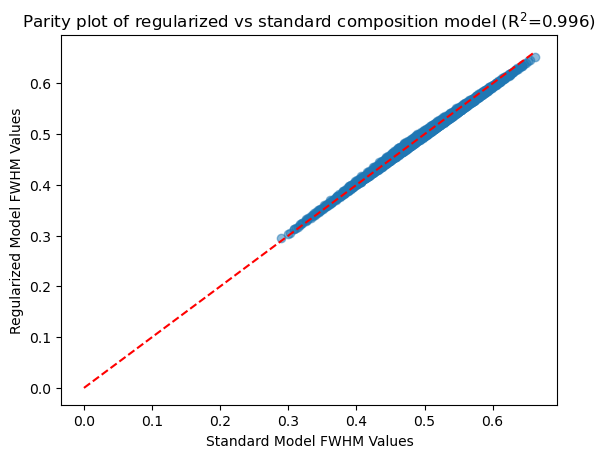

<Figure size 320x160 with 0 Axes>

In [55]:
parity_plot_custom(regular_quaternary_composition_predictions, quaternary_composition_predictions,
                  title="Parity plot of regularized vs standard composition model")

### 4.2.2 Comparing standard matminer model (Assignment 5) and regularized matminer model

In [56]:
regular_quaternary_matminer_predictions = pd.read_csv("lab5matminermodelFWHM.csv")

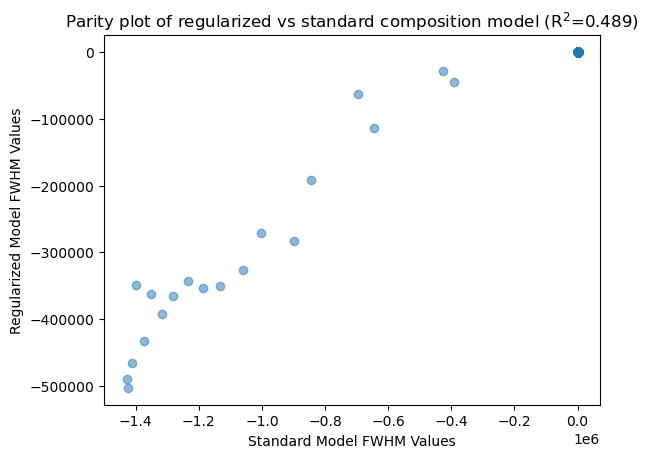

<Figure size 320x160 with 0 Axes>

In [57]:
parity_plot_custom(regular_quaternary_matminer_predictions, quaternary_matminer_predictions,
                  title="Parity plot of regularized vs standard composition model")

This plot is difficult to interpret. Upon closer inspection, this is because the regularized MatMiner model (from this assignment) has a several, extremely negative FWHM outliers. To solve this issue, only positive FWHM predicted values from both models will be plotted (the negative values are replaced with a 0 using the code in the following two blocks):

In [58]:
adjusted_quat_matminer_predictions = quaternary_matminer_predictions
adjusted_quat_matminer_predictions[adjusted_quat_matminer_predictions < 0] = 0
len(adjusted_quat_matminer_predictions)

1584

In [59]:
adjusted_reg_matminer_predictions = regular_quaternary_matminer_predictions
adjusted_reg_matminer_predictions[adjusted_reg_matminer_predictions < 0] = 0
len(adjusted_reg_matminer_predictions)

1584

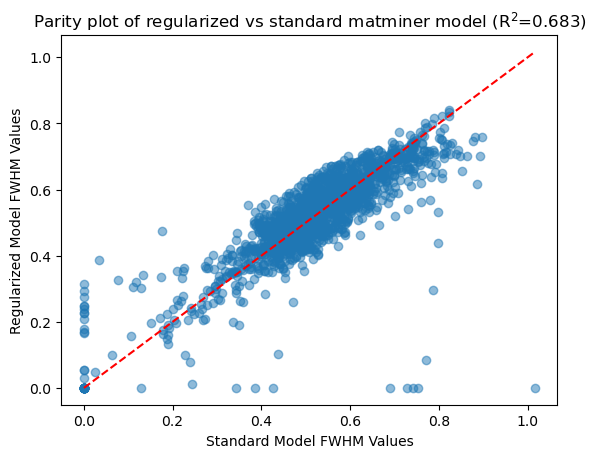

<Figure size 320x160 with 0 Axes>

In [60]:
parity_plot_custom(adjusted_reg_matminer_predictions, adjusted_quat_matminer_predictions,
                  title="Parity plot of regularized vs standard matminer model")

In [61]:
# Get the two features with the highest magnitude of coefficients from regularized matminer model
get_names_important_features(full_matminer_model, 2, full_quaternary_x.columns)

Index(['Co', 'Miedema_deltaH_ss_min'], dtype='object')

In [62]:
# Get the two features with the highest magnitude of coefficients from regularized composition model
get_names_important_features(full_composition_model, 2,full_quaternary_x_composition.columns)

Index(['Cr', 'Co'], dtype='object')

# 5.0 Summary

The parity plot of the predictions of the standard composition vs regularized composition model (Section 4.2.1) show that the both models have highly similar FWHM predictions of the quaternary system. This is further evident by the calculated R-squared value of 0.996. This suggests that regularization does not significantly change the predicted FWHM value; or equiavlently, that the parameter weights (coefficients) for each element's composition are roughly equal to that of a standard linear model. Overall, this suggests that regularization isn't required for a model trained on composition alone.

The parity plot of the predictions of the standard matminer vs regularized matminer model (Section 4.2.2) initially demonstrated that the regularized model predicts extreme negative values (on the order of negative 100 thousant) for certain data points while the standard matminer model does not make equally extreme predictions. However, once the negative FWHM values from both matminer models are removed, the models fits appear to be of comparable quality, as suggested by the R-squared of 0.683. The predicted values from the regularized matminer model appear to have a lower variability compared to the standard linear model as well (i.e. the regularized model has FWHM predictions betweem 0 and 0.8 whereas the standard model predicts values between 0 and 1).

For the regularized composition model, the features that were the most important (as measured by the magnitude of the coefficients) features are Cr and Co fraction. From online searching, this heuristic appears to align with convetional materials science knowledge. For example, from https://doi.org/10.1016/j.matchemphys.2008.08.057, it appears that Cr content decreases glass-forming ability in a Fe-based system. Also https://doi.org/10.1007/s11433-012-4919-y suggests that Co content also decreases glass-forming ability on a different allow system. While the quaternary system is not exactly the same systems studied in these papers, the fact that the composition model's predictions is also heavilty influence by the Cr and Co compositions suggests that this model is somewhat physically grounded.

For the regularized matminer model, the features that were most important (as measured by the magnitude of the coefficients) features are the Co fraction and Miedema_deltaH_ss_min. Similar to the regularized composition model, Co fraction is an important feature that impacts glass-forming ability (https://doi.org/10.1007/s11433-012-4919-y), and thus, affects the predicted FWHM valued. The fact that the Miedema formation enthalpy carries high importance in the regularized model suggests that is reasonably well-physically grounded as well, as the Miedema model calculates formation enthalpies of compounds (according to Matminer documentation).

Overall both models did a good job in picking (i.e. assigning high weights to) physically meaningful parameters, given their respective feature sets.